# HW3 

### Yeqing Liu

In [133]:
import os
from keras.applications import VGG16
from keras.optimizers import RMSprop
from keras.layers import Input, Dense,Conv1D, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Reshape, Embedding, LSTM, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras.preprocessing.image import img_to_array, array_to_img
from keras import backend as K
from keras.datasets import fashion_mnist
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import cv2
import nltk
import string
import tensorflow as tf
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import roc_curve, auc
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# 1 Autoencoder

In [17]:
#load data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format


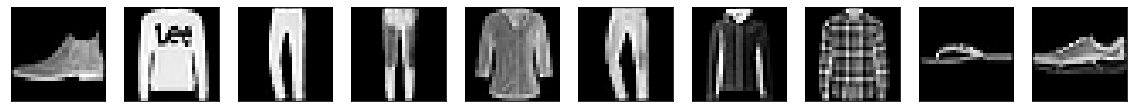

In [18]:
# show 10 pictures in size of 28*28
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [19]:
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (5, 5), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
# epoch=3
autoencoder.fit(x_train, x_train,
                epochs=3,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 374s 6ms/step - loss: 0.3178 - val_loss: 0.2940
Epoch 2/3
60000/60000 [==============================] - 370s 6ms/step - loss: 0.2840 - val_loss: 0.2806
Epoch 3/3
60000/60000 [==============================] - 345s 6ms/step - loss: 0.2771 - val_loss: 0.2745


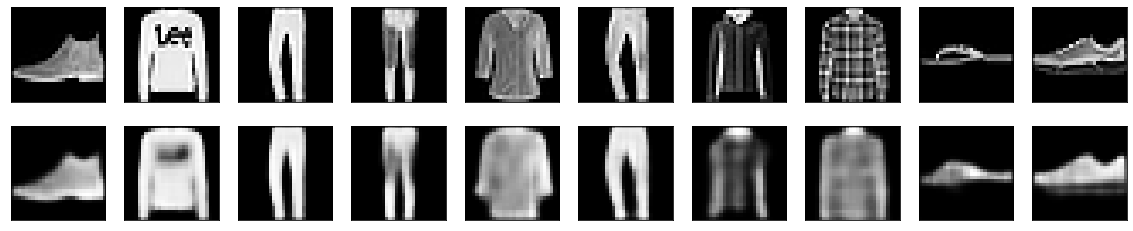

In [14]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 2 Image Classification

### 2.1 Deep CNN

In [43]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# normalize data
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)  
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# make a categorical clothing type
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [46]:
model = Sequential()
model.add(Conv2D(filters = 128,kernel_size=(3, 3),activation='relu', strides=2,padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64,kernel_size=(3, 3), activation='relu', strides=2, padding='valid'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [47]:
model_training = model.fit(X_train,y_train,
                             batch_size=128,
                             epochs=5,
                             validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 21s 345us/step - loss: 1.1992 - acc: 0.5572 - val_loss: 0.6525 - val_acc: 0.7759
Epoch 2/5
60000/60000 [==============================] - 17s 287us/step - loss: 0.8007 - acc: 0.7149 - val_loss: 0.5674 - val_acc: 0.7950
Epoch 3/5
60000/60000 [==============================] - 17s 291us/step - loss: 0.7166 - acc: 0.7496 - val_loss: 0.5295 - val_acc: 0.8122
Epoch 4/5
60000/60000 [==============================] - 17s 280us/step - loss: 0.6719 - acc: 0.7646 - val_loss: 0.5123 - val_acc: 0.8143
Epoch 5/5
60000/60000 [==============================] - 17s 277us/step - loss: 0.6459 - acc: 0.7735 - val_loss: 0.4915 - val_acc: 0.8231


In [48]:
test_eval = model.evaluate(X_test, y_test)
train_eval = model.evaluate(X_train, y_train)
print('The lose of the model on test dataset is',test_eval[0])
print('The accuracy of the model on test dataset is',test_eval[1])

print('The lose of the model on training dataset is',train_eval[0])
print('The accuracy of the model on training dataset is',train_eval[1])

60000/60000 [==============================] - 7s 124us/step
The lose of the model on test dataset is 0.4914638301849365
The accuracy of the model on test dataset is 0.8231
The lose of the model on training dataset is 0.4608131427447001
The accuracy of the model on training dataset is 0.8305666666666667


CNN architectural:
There are 2 convolution layers in this model, these layers contain 128, 64 of 3x3 filters, respectively. Then I used Max pool in size 2x2 with strides=2 on each convolution layers. Each pool layer is followed by a 50% drop off.
I selected softmax and relu as the activation functions.

Evalustion: 
The lose of the model on test dataset is 0.49.
The accuracy of the model on test dataset is 82%.
The lose of the model on training dataset is 0.46.
The accuracy of the model on training dataset is 83%.

### 2.2 Transfer Learning

In [70]:
# load data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)  
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# reshape the dataset
x_train = np.asarray([cv2.resize(x, (48,48)) for x in x_train])
x_test = np.asarray([cv2.resize(x, (48,48)) for x in x_test])
x_train = x_train.reshape(x_train.shape[0], 48, 48,1)
x_test  = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_train = x_train.repeat(3, axis=-1)
x_test  = x_test.repeat(3, axis=-1)


In [56]:
from keras.applications import VGG19
# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (48, 48, 3))
trans_learning_model = Sequential()
trans_learning_model.add(vgg16)
trans_learning_model.add(Flatten())
trans_learning_model.add(Dense(64, activation="relu"))
trans_learning_model.add(Dense(10, activation='softmax'))

vgg19.trainable = False
import keras
# Compile the model
trans_learning_model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [58]:
# fit the model, select 20% as training 
trans_learning_model.fit(x_train, y_train,
          epochs=3,
          batch_size=128,
          validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 1540s 26ms/step - loss: 0.4750 - acc: 0.8313 - val_loss: 0.4635 - val_acc: 0.8336
Epoch 2/3
60000/60000 [==============================] - 1537s 26ms/step - loss: 0.4089 - acc: 0.8524 - val_loss: 0.4197 - val_acc: 0.8486
Epoch 3/3
60000/60000 [==============================] - 1485s 25ms/step - loss: 0.3808 - acc: 0.8618 - val_loss: 0.4061 - val_acc: 0.8551


In [71]:
#Evaluate model 
test_eval = trans_learning_model.evaluate(x_test, y_test)
train_eval = trans_learning_model.evaluate(x_train, y_train)

60000/60000 [==============================] - 1331s 22ms/step


In [61]:
print('Test loss and accuracy on test set are', test_eval[0],'and',test_eval[1],'respectively')
print('Test loss and accuracy on train set are', train_eval[0],'and',train_eval[1],'respectively')

Test loss and accuracy on test set are 0.40609159989356997 and 0.8551 respectively
Test loss and accuracy on train set are 0.36985628816286725 and 0.8649166666666667 respectively


Evaluation: 
Test loss and accuracy are 0.406 and 85.5%, respectively.
Training loss and accuracy are 0.369 and 86.5%, respectively.

# 3 Text Classification

### 3.1 RNN

In [63]:
tweets=pd.read_csv('/Users/qq/Desktop/y2/deep learning/hw/tweets_with_labels.csv',sep='\t')
tweets.dropna()
tweets.head()

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [124]:
# preprocess the data
from gensim.corpora import Dictionary
from sklearn.model_selection import train_test_split
tweet = list(tweets['tweet'].map(lambda x:list(x)))
dct = Dictionary(tweet)
X = list(tweets['tweet'].map(lambda x: dct.doc2idx(list(x))))
y =  tweets.iloc[:,2:17]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [125]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Embedding
from keras.preprocessing.text import Tokenizer, one_hot
from keras.optimizers import RMSprop
from keras.preprocessing import sequence

maxlen = 50
max_features = len(dct)
X_train = sequence.pad_sequences(X_train, maxlen, padding="post", truncating="post")
X_test = sequence.pad_sequences(X_test, maxlen, padding="post", truncating="post")


In [126]:
tweet_RNN = Sequential()
tweet_RNN.add(Embedding(max_features, maxlen))
tweet_RNN.add(SimpleRNN(32))
tweet_RNN.add(Dense(15, activation='sigmoid'))
tweet_RNN.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [127]:
hisory_RNN = tweet_RNN.fit(X_train, y_train, epochs=5, batch_size=128, 
            validation_data=(X_test, y_test))

Train on 54562 samples, validate on 23384 samples
Epoch 1/5
54562/54562 [==============================] - 33s 596us/step - loss: 0.2590 - acc: 0.8691 - val_loss: 0.2328 - val_acc: 0.8742
Epoch 2/5
54562/54562 [==============================] - 25s 462us/step - loss: 0.2317 - acc: 0.8748 - val_loss: 0.2316 - val_acc: 0.8741
Epoch 3/5
54562/54562 [==============================] - 24s 433us/step - loss: 0.2298 - acc: 0.8749 - val_loss: 0.2271 - val_acc: 0.8745
Epoch 4/5
54562/54562 [==============================] - 22s 403us/step - loss: 0.2267 - acc: 0.8749 - val_loss: 0.2253 - val_acc: 0.8745
Epoch 5/5
54562/54562 [==============================] - 23s 412us/step - loss: 0.2247 - acc: 0.8750 - val_loss: 0.2264 - val_acc: 0.8745


In [128]:
test_score = tweet_RNN.evaluate(X_test, y_test)
# Test Error
print('Test loss is', test_score[0])
print('Test accuray is',test_score[1])

23384/23384 [==============================] - 6s 243us/step
Test loss is 0.22638710104171192
Test accuray is 0.8744954161761438


The accuracy of the RNN is 87.4% and loss is 0.226, which is not bad.

### 3.2 CNN

In [129]:
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, GlobalMaxPooling1D
tweet_CNN = Sequential()
tweet_CNN.add(Embedding(max_features, maxlen))
tweet_CNN.add(Dropout(0.25))
tweet_CNN.add(Conv1D(64, 5, activation='relu'))
tweet_CNN.add(GlobalMaxPooling1D())
tweet_CNN.add(Dense(15, activation='sigmoid'))
tweet_CNN.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])

hisory_CNN = tweet_CNN.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_test, y_test))

Train on 54562 samples, validate on 23384 samples
Epoch 1/5
54562/54562 [==============================] - 46s 841us/step - loss: 0.2466 - acc: 0.8724 - val_loss: 0.1810 - val_acc: 0.8908
Epoch 2/5
54562/54562 [==============================] - 35s 634us/step - loss: 0.1681 - acc: 0.8950 - val_loss: 0.1597 - val_acc: 0.8967
Epoch 3/5
54562/54562 [==============================] - 24s 447us/step - loss: 0.1569 - acc: 0.8983 - val_loss: 0.1539 - val_acc: 0.8983
Epoch 4/5
54562/54562 [==============================] - 25s 450us/step - loss: 0.1534 - acc: 0.8991 - val_loss: 0.1521 - val_acc: 0.8986
Epoch 5/5
54562/54562 [==============================] - 24s 435us/step - loss: 0.1515 - acc: 0.8995 - val_loss: 0.1507 - val_acc: 0.8991


In [130]:
cnn_evaluation=tweet_CNN.evaluate(X_test, y_test)
print('The lose of test is',cnn_evaluation[0])
print('The accuaracy of test is',cnn_evaluation[1])

23384/23384 [==============================] - 2s 107us/step
The lose of test is 0.15065135718350373
The accuaracy of test is 0.8991333426288901


The accuracy of the CNN is 90% and loss is 0.15, which is not bad.


### 3.3 ROC 

In [148]:
from sklearn.metrics import roc_curve, auc
def plot_roc(test_TL,test_TC,test_target,i):
    fprl, tprl, _ = roc_curve(test_target,test_TL)
    fprc, tprc,_ = roc_curve(test_target,test_TC)
    plt.figure()
    lw = 0.5
    # RNN
    plt.plot(fprl, tprl, color='red',lw=lw, label='ROC curve for RNN (area = %0.3f)' % auc(fprl,tprl))
    # CNN
    plt.plot(fprc, tprc, color='blue',lw=lw, label='ROC curve for CNN (area = %0.3f)' % auc(fprc,tprc))
    plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for k%s' % str(i+1))
    plt.legend(loc="lower right")
    plt.show()

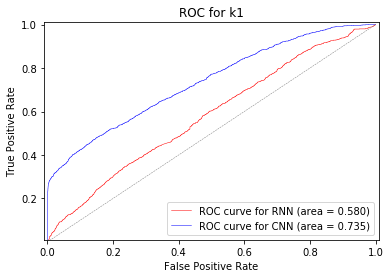

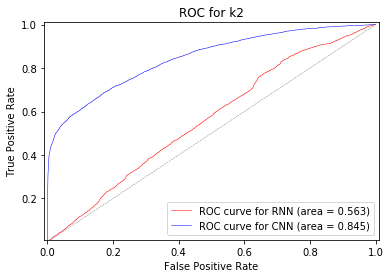

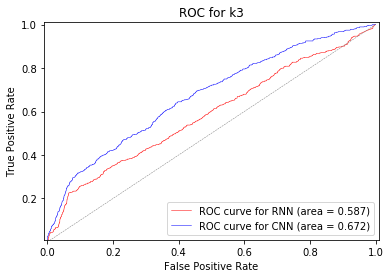

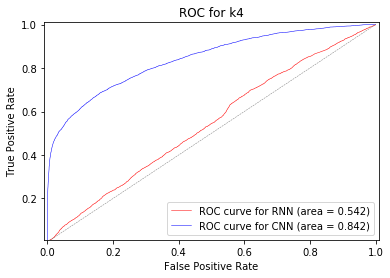

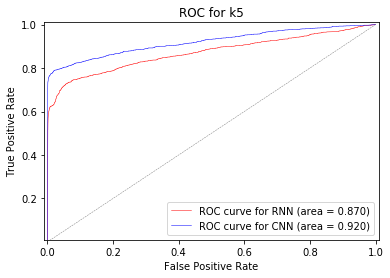

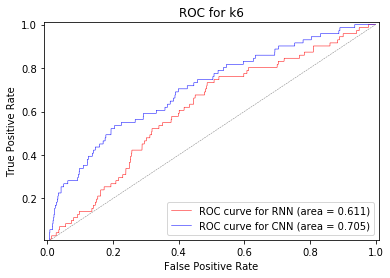

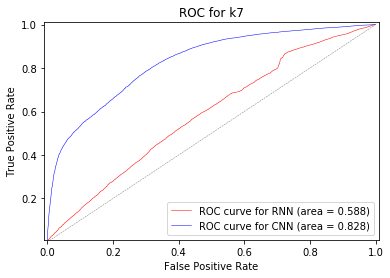

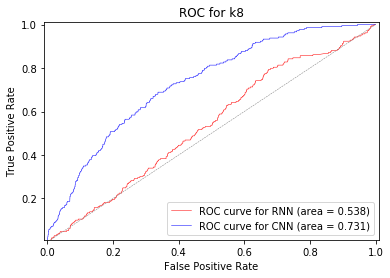

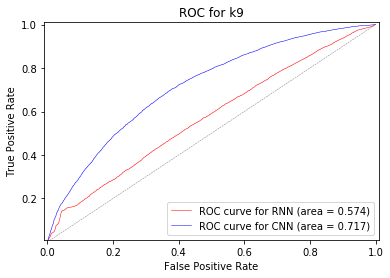

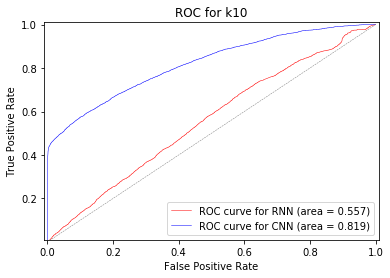

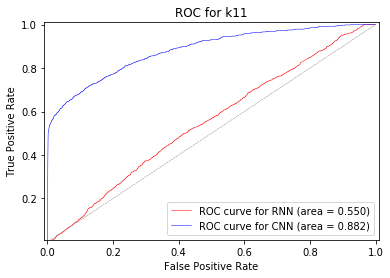

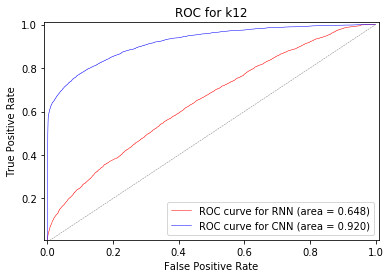

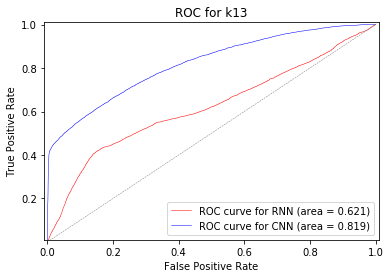

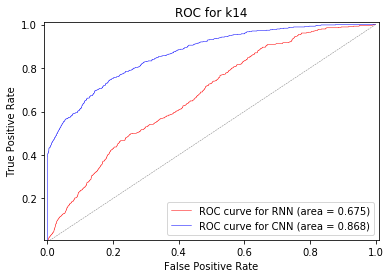

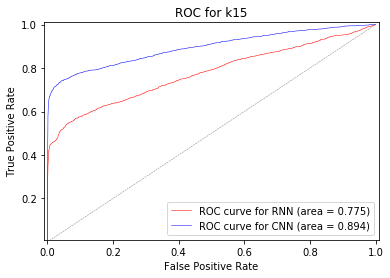

In [149]:
for i in range(15):
    test_TL = tweet_RNN.model.predict(X_test)[:,i]
    test_TC = tweet_CNN.model.predict(X_test)[:,i]
    test_target = y_test.iloc[:,i]>0
    plot_roc(test_TL,test_TC,test_target,i)

Overall, CNN performs beter than RNN